# 2. Preprocessing and EDA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
from folium.plugins import FloatImage
import folium # plotting library for maps
from utility.utils import setup_autosave, save_plot

# Plotly
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
%matplotlib inline

In [262]:
## loading the dataset
import joblib
df = joblib.load("artifacts/cleaned_data.pkl")

In [263]:
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost,reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [264]:
# Changing some columns names for better understanding
df=df.rename(columns={'listed_in(type)':'type','listed_in(city)':'city'})


In [265]:
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost,reviews_list,menu_item,type,city
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [266]:
# description of the dataset
df.describe()

,votes
count,51717.000000
mean,283.697527
std,803.838853
min,0.000000
25%,7.000000
50%,41.000000
75%,198.000000
max,16832.000000


In [267]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           51717 non-null  object
 1   address       51717 non-null  object
 2   name          51717 non-null  object
 3   online_order  51717 non-null  object
 4   book_table    51717 non-null  object
 5   rate          51717 non-null  object
 6   votes         51717 non-null  int64 
 7   phone         51717 non-null  object
 8   location      51717 non-null  object
 9   rest_type     51717 non-null  object
 10  dish_liked    51717 non-null  object
 11  cuisines      51717 non-null  object
 12  approx_cost   51371 non-null  object
 13  reviews_list  51717 non-null  object
 14  menu_item     51717 non-null  object
 15  type          51717 non-null  object
 16  city          51717 non-null  object
dtypes: int64(1), object(16)
memory usage: 6.7+ MB


#### Dropping Columns that are not required for our analysis
- phone
- dish_liked
- address
- menu_item
- city
- url

In [268]:
# df.drop(['url','phone','dish_liked','address','menu_item',"city"],axis=1, inplace=True)

In [269]:
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost,reviews_list,menu_item,type,city
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [270]:
# df.dropna()

In [271]:
## appprox_cost missing value imputation with the mean value
df.shape
df['approx_cost'].unique()
df['approx_cost'].nunique()
df['approx_cost'].dtype

dtype('O')

In [272]:
## changing the datatype of approx_cost to float
df['approx_cost'] = df['approx_cost'].astype(str)
df['approx_cost'] = df['approx_cost'].apply(lambda x: x.replace(',','.'))
df['approx_cost'] = df['approx_cost'].astype(float)

now, imputatio with the mean would be easy

In [273]:
## appprox_cost missing value imputation with the mean value
approx_cost_mean = df['approx_cost'].mean()
approx_cost_mean

# filling na with mean value
df['approx_cost'] = df['approx_cost'].fillna(approx_cost_mean)
df['approx_cost'] = df['approx_cost'].astype(int)

### Auto saving visualization inside folder->
from utils.py

In [274]:
from utility.utils import save_plot, setup_autosave
setup_autosave()

✅ Auto-save mode activated. Use plt.show('filename') to save automatically.


✅ Auto-saved: visualizations/approx_cost_distribution.png.png


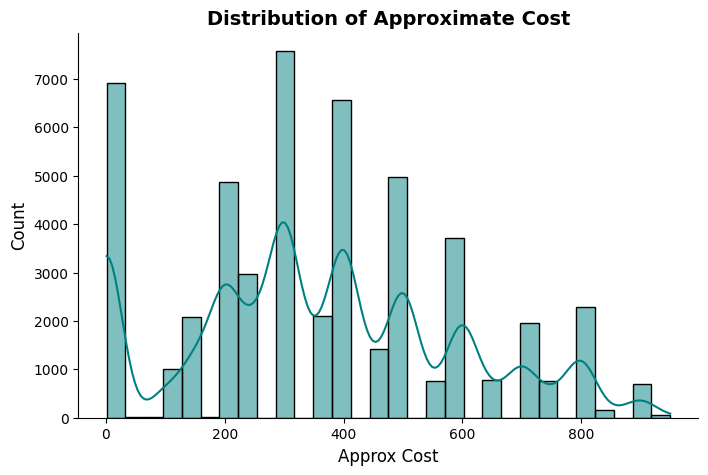

In [275]:
plt.figure(figsize=(8,5))
sns.histplot(df['approx_cost'], bins=30, kde=True, color='teal', edgecolor='black')
plt.title("Distribution of Approximate Cost", fontsize=14, fontweight='bold')
plt.xlabel("Approx Cost", fontsize=12)
plt.ylabel("Count", fontsize=12)
sns.despine()  # Remove top and right spines for a cleaner look (chatGPT suggestion) 
plt.show('approx_cost_distribution.png')

In [276]:
## Checking for missing values
df['approx_cost'].isnull().sum()
df[df['approx_cost']==''].shape[0] # done

0

In [277]:
## checking for any other missing values in the dataset
df.isnull().sum()

url             0
address         0
name            0
online_order    0
book_table      0
rate            0
votes           0
phone           0
location        0
rest_type       0
dish_liked      0
cuisines        0
approx_cost     0
reviews_list    0
menu_item       0
type            0
city            0
dtype: int64

In [278]:
## checkin for blank values in the dataset
for column in df.columns:
    print(f"{column} : {df[df[column]==''].shape[0]}")

url : 0
address : 0
name : 0
online_order : 0
book_table : 0
rate : 7844
votes : 0
phone : 1208
location : 21
rest_type : 227
dish_liked : 28078
cuisines : 45
approx_cost : 0
reviews_list : 0
menu_item : 0
type : 0
city : 0


In [279]:
df.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost', 'reviews_list', 'menu_item', 'type', 'city'],
      dtype='object')

In [280]:
## handling "rate" column
df['rate'].unique()
df = df[df['rate'] != 'NEW']
df = df[df['rate'] != ""].reset_index(drop=True)
df['rate'].unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', '2.9/5', '3.5/5', '2.6/5', '3.8 /5', '3.4/5', '4.5/5',
       '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5', '3.4 /5',
       '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5', '4.1 /5',
       '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5', '3.5 /5',
       '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5', '4.3 /5',
       '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5', '4.9 /5',
       '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5', '2.1 /5',
       '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

In [281]:
## also need to remove the "/5" from the rate column values
def remove_slash(data, column):
    removed = lambda x: x.replace('/5', '') if type(x) == str else x
    data[column] = data[column].apply(removed).astype(float)
    return data

In [282]:
## removing the /5 from rate column using the function
df = remove_slash(df, 'rate')
df['rate'].head() 
## Checking the rate column values after removing /5
df['rate'].unique()

array([4.1, 3.8, 3.7, 3.6, 4.6, 4. , 4.2, 3.9, 3.1, 3. , 3.2, 3.3, 2.8,
       4.4, 4.3, 2.9, 3.5, 2.6, 3.4, 4.5, 2.5, 2.7, 4.7, 2.4, 2.2, 2.3,
       4.8, 4.9, 2.1, 2. , 1.8])

✅ Auto-saved: visualizations/restaurant_ratings_distribution.png.png


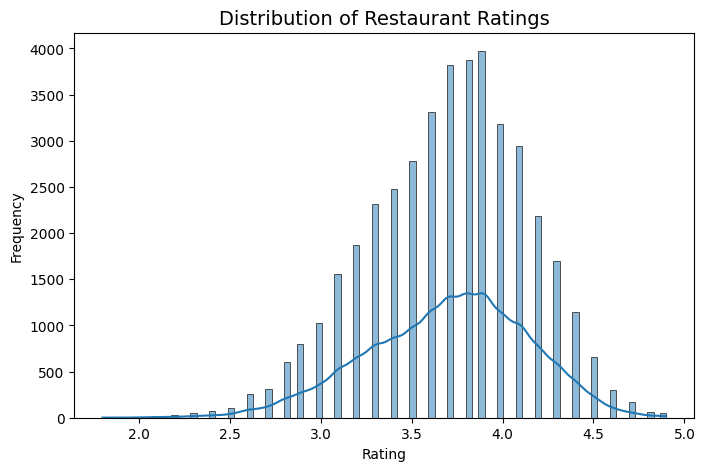

In [283]:
plt.figure(figsize=(8,5))
sns.histplot(df['rate'], kde=True, edgecolor='black')
plt.title("Distribution of Restaurant Ratings", fontsize=14)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show("restaurant_ratings_distribution.png")

In [284]:
# checking skewness in the rate column
print('skewness->',df.rate.skew()) 
# checking blank values in rate column
df[df['rate']==""].shape[0]
df['rate'].unique()

skewness-> -0.3286007981782886


array([4.1, 3.8, 3.7, 3.6, 4.6, 4. , 4.2, 3.9, 3.1, 3. , 3.2, 3.3, 2.8,
       4.4, 4.3, 2.9, 3.5, 2.6, 3.4, 4.5, 2.5, 2.7, 4.7, 2.4, 2.2, 2.3,
       4.8, 4.9, 2.1, 2. , 1.8])

### Note-> we still have "Blank values" in the dataset that we have replaced for NaN

In [285]:
## checkin for blank values in the dataset
for column in df.columns:
    print(f"{column} : {df[df[column]==''].shape[0]}")

url : 0
address : 0
name : 0
online_order : 0
book_table : 0
rate : 0
votes : 0
phone : 814
location : 0
rest_type : 149
dish_liked : 18203
cuisines : 11
approx_cost : 0
reviews_list : 0
menu_item : 0
type : 0
city : 0


In [286]:
histo = df.groupby('name')['address'].count()
# Lets take the top 50 restaurantsand plot bar graph
histo = histo.sort_values()[-30:]

✅ Auto-saved: visualizations/top_30_restaurants_by_count.png.png


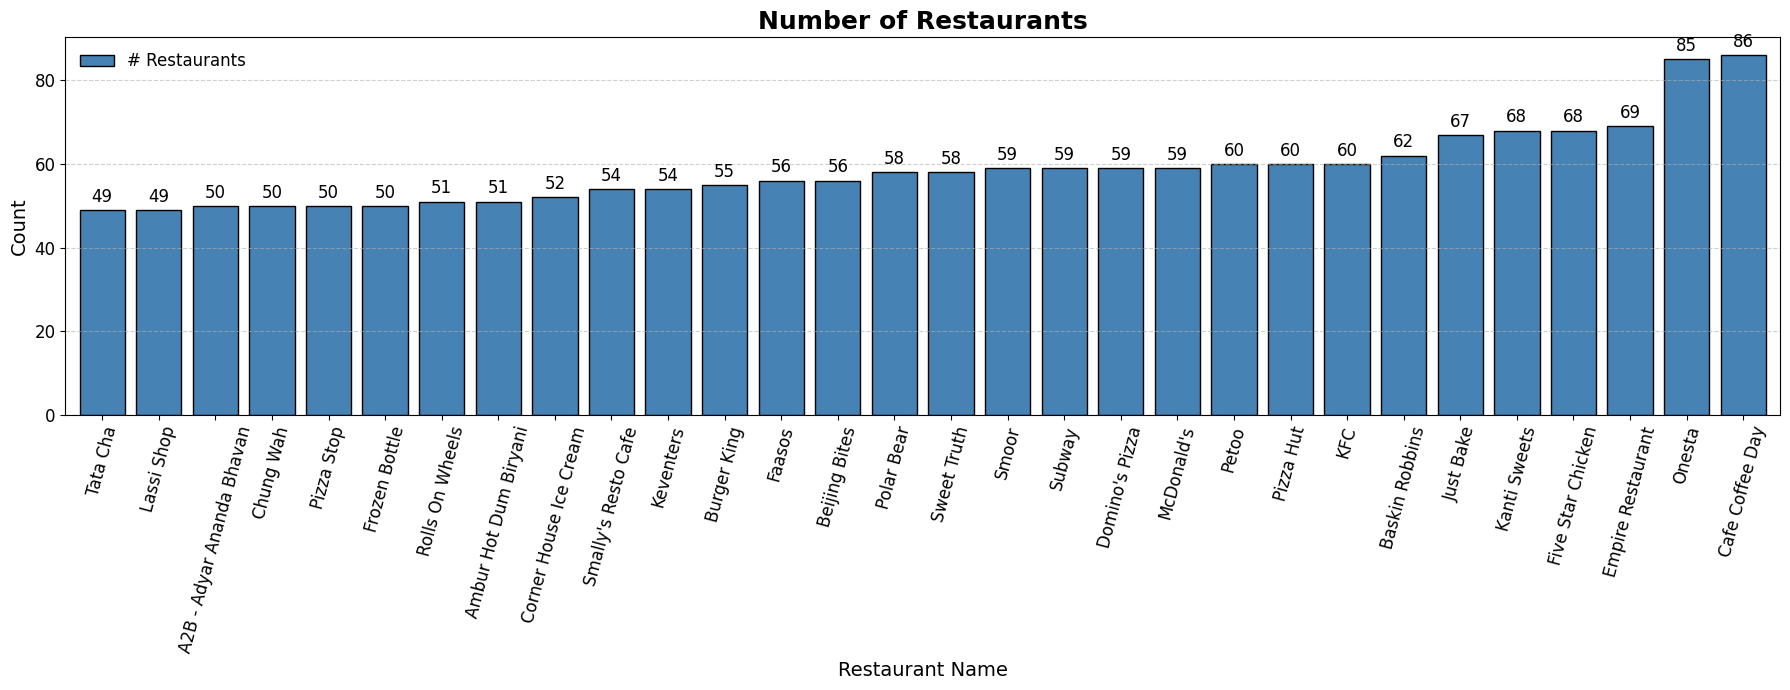

In [287]:
# Simple, beautiful, and professional bar plot
# used ChatGPT to beautify the plot->
ax = histo.plot(
    kind='bar',
    figsize=(18, 7),
    rot=75,
    width=0.8,
    color='steelblue',
    edgecolor='black'
)

# Add value labels on bars
for rect in ax.patches:
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        rect.get_height() + 1,
        f'{int(rect.get_height())}',
        ha='center',
        va='bottom',
        fontsize=12,
        color='black'
    )

# Beautify the chart
ax.set_title('Number of Restaurants', fontsize=18, fontweight='bold')
ax.set_xlabel('Restaurant Name', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_facecolor('white')
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Simplified legend
ax.legend(['# Restaurants'], fontsize=12, frameon=False)

plt.tight_layout()
plt.show("top_30_restaurants_by_count.png")


- "Cafe Coffee Day" has literally 86 restaurants in Bengaluru!

### Word Cloud 

✅ Auto-saved: visualizations/Most Frequent Restaurant Names.png.png


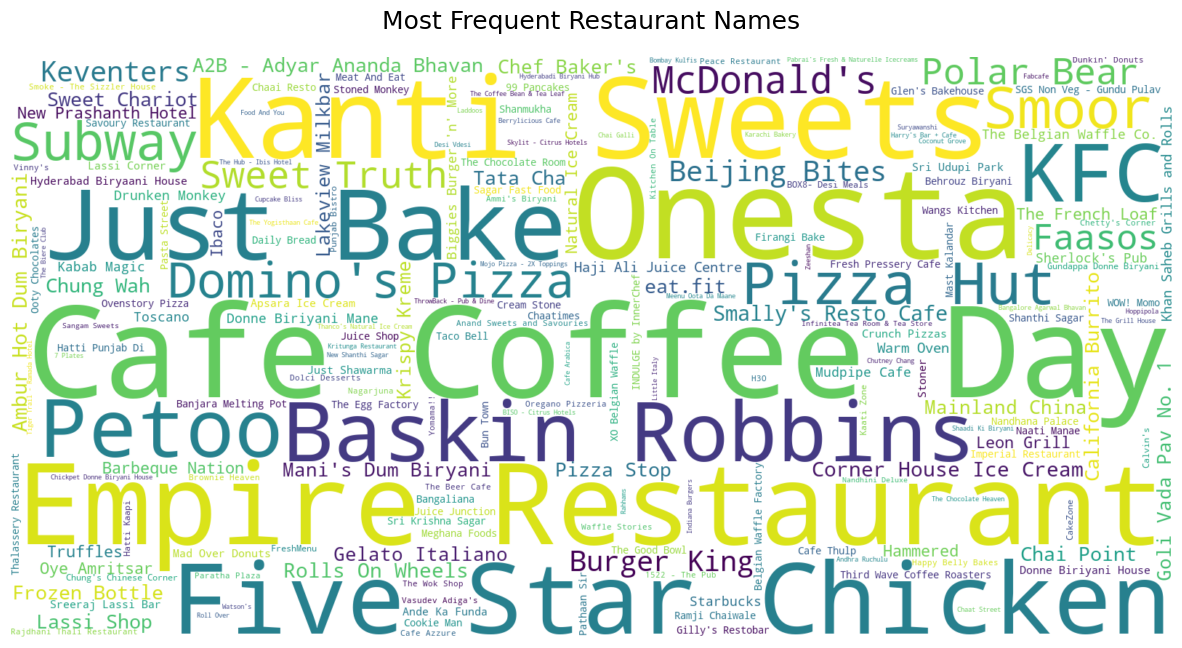

In [288]:
from wordcloud import WordCloud
## used ChatGPT to beautify the wordcloud plot->
# Generate word cloud from restaurant names
wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color='white',
    colormap='viridis',
    max_words=200,
    relative_scaling=0.5
).generate_from_frequencies(df['name'].value_counts())

# Display the word cloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Restaurant Names", fontsize=18, pad=20)
plt.show("Most Frequent Restaurant Names.png")


- Cafe Coffee Day, salute 🫡

## How does various Features affect Rating of the Restaurant 

### Box Plotting

In [289]:
#print(df['rate'].unique())
df.head(2)

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost,reviews_list,menu_item,type,city
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari


In [290]:
import matplotlib.pyplot as plt
import seaborn as sns

def box_plot(df, col, plot_name):
    # Sort categories by median rate
    sorted_vals = df.groupby(col)['rate'].median().sort_values()

    # Plot
    plt.figure(figsize=(15, 8))
    sns.boxplot(x=col, y='rate', data=df, order=sorted_vals.index, palette='crest')

    plt.title(f"Distribution of Ratings by {col.capitalize()}", fontsize=16)
    plt.xlabel(col.capitalize(), fontsize=12)
    plt.ylabel("Rating", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show(plot_name)
    print(f"Boxplot saved as {plot_name}")


/var/folders/49/z4dsjwnj3bz30nknl9ffld4h0000gn/T/ipykernel_16791/4284245255.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='rate', data=df, order=sorted_vals.index, palette='crest')


✅ Auto-saved: visualizations/city_vs_rating_boxplot.png


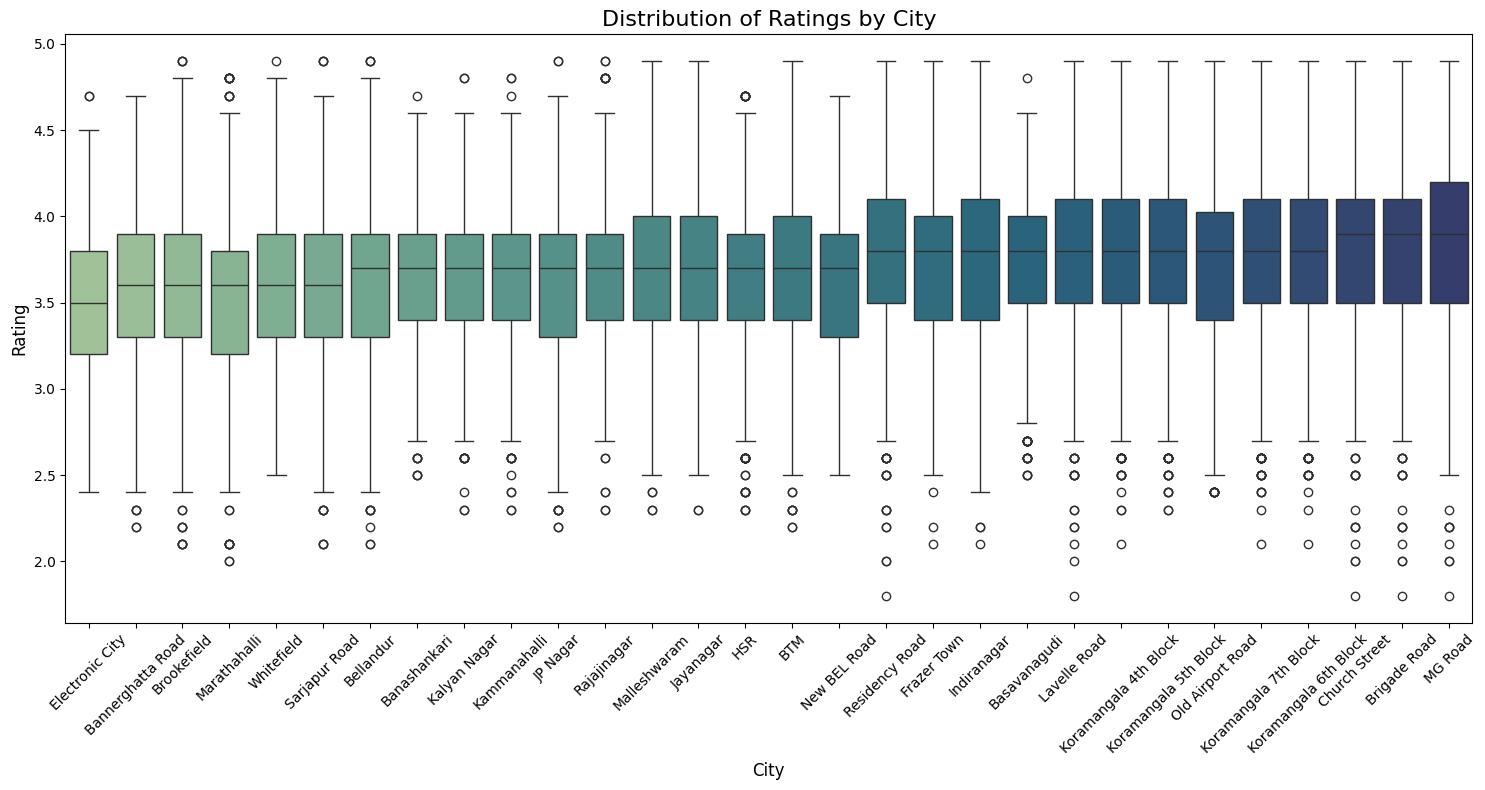

Boxplot saved as city_vs_rating_boxplot


In [291]:
box_plot(df, 'city', "city_vs_rating_boxplot")


In [292]:
df.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost', 'reviews_list', 'menu_item', 'type', 'city'],
      dtype='object')

- bookingg vs restaurant rating 

/var/folders/49/z4dsjwnj3bz30nknl9ffld4h0000gn/T/ipykernel_16791/4284245255.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='rate', data=df, order=sorted_vals.index, palette='crest')


✅ Auto-saved: visualizations/booking_vs_rating_boxplot.png


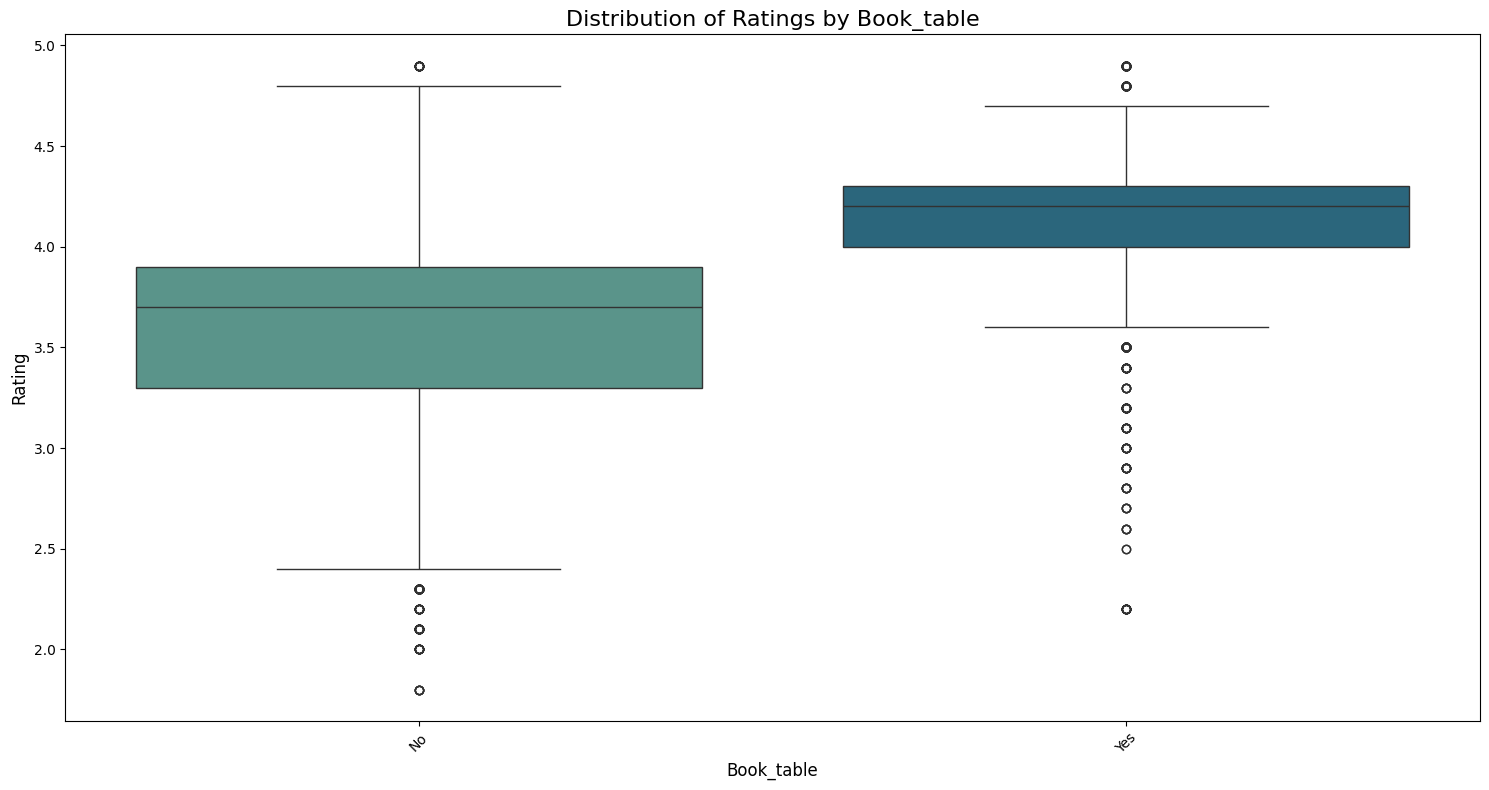

Boxplot saved as booking_vs_rating_boxplot


In [293]:
box_plot(df, 'book_table', plot_name='booking_vs_rating_boxplot')


#### finding->
- Higher Rating leads to Higher Table booking

Restaurant Type vs Rating BoxPlot

/var/folders/49/z4dsjwnj3bz30nknl9ffld4h0000gn/T/ipykernel_16791/4284245255.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='rate', data=df, order=sorted_vals.index, palette='crest')


✅ Auto-saved: visualizations/restaurant_type_vs_rating_boxplot.png


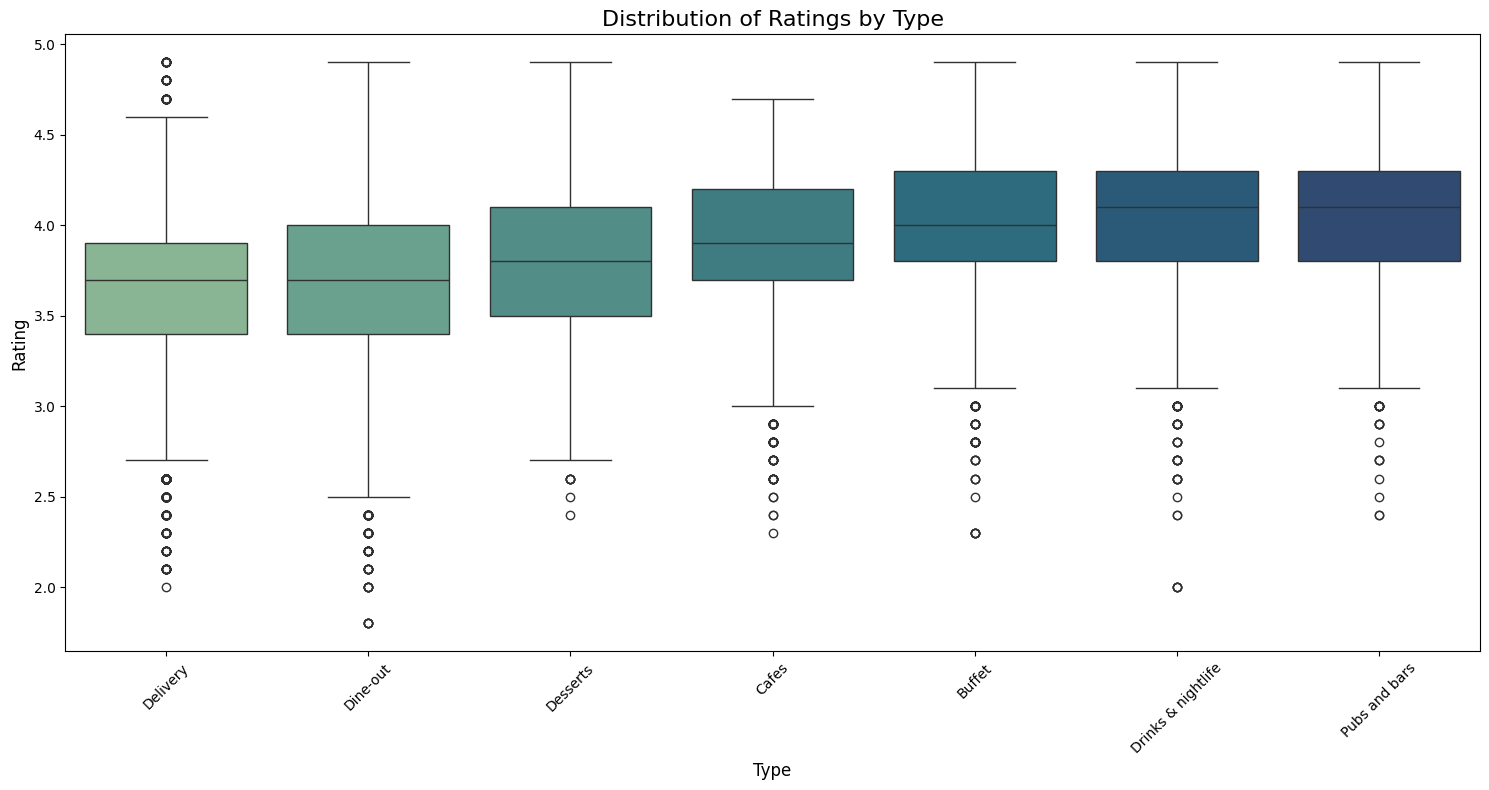

Boxplot saved as restaurant_type_vs_rating_boxplot


In [294]:
box_plot(df, 'type', "restaurant_type_vs_rating_boxplot")

### Finding->
- "pubs and bars" restuarants  and "Drinks & nightlife" restaurants have usually higher rating

/var/folders/49/z4dsjwnj3bz30nknl9ffld4h0000gn/T/ipykernel_16791/4284245255.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='rate', data=df, order=sorted_vals.index, palette='crest')


✅ Auto-saved: visualizations/online_order_vs_rating_boxplot.png


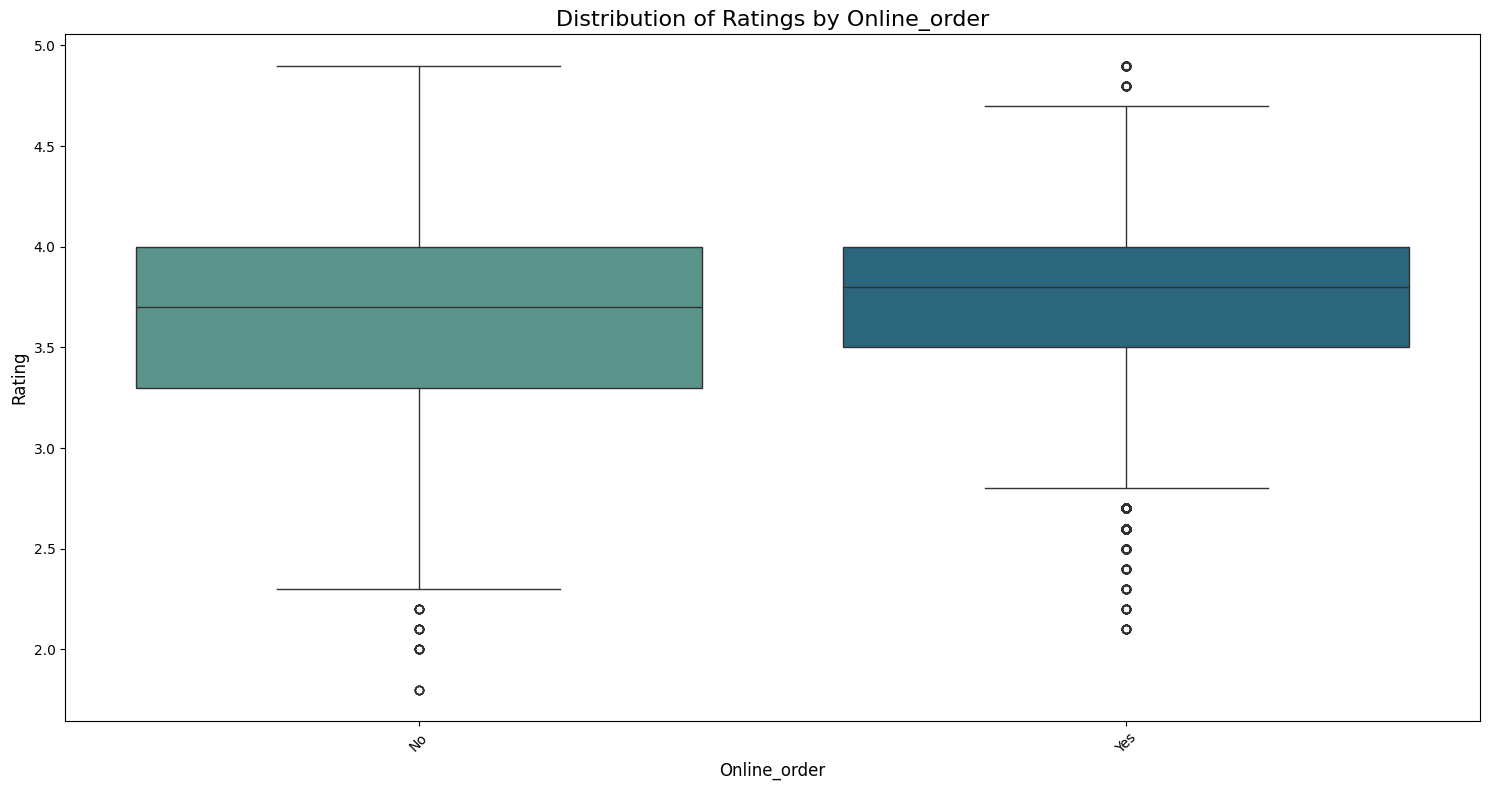

Boxplot saved as online_order_vs_rating_boxplot


In [295]:
box_plot(df, 'online_order', "online_order_vs_rating_boxplot")

### Hist Plots

- Does Rating affect Online Order Quantity?

In [296]:
## defining hist_plot function
## used ChatGPT to beautify the hist_plot function->
def hist_plot(df, col, plot_name=None, bins=10):
    """
     histogram with KDE for any numeric column.
    """
    # Clean numeric data
    data = pd.to_numeric(df[col], errors='coerce').dropna()

    # Plot
    plt.figure(figsize=(12,6))
    sns.histplot(data, bins=bins, kde=True, color="#3498db", edgecolor='black', alpha=0.7)
    
    plt.title(f"{col.capitalize()} Distribution", fontsize=16)
    plt.xlabel(col.capitalize())
    plt.ylabel("Count")
    sns.despine()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show(plot_name)
    print(f"Histogram saved as {plot_name}")

In [297]:
## online_order column is categorical with Yes/No values
## modifying hist_plot function to handle Yes/No categorical data
# plotting histogram for online_order  vs rating
def hist_plot(df, col, plot_name=None, bins=15):
    """
    Simple and beautiful histogram for numeric columns.
    Automatically handles Yes/No categorical data.
    """
    # Handle Yes/No categorical case
    if df[col].dtype == 'object':
        if set(df[col].dropna().unique()) == {'Yes', 'No'}:
            df = df.copy()
            df[col] = df[col].map({'Yes': 1, 'No': 0})
        else:
            print(f"⚠️ '{col}' is non-numeric and not a Yes/No column — skipping.")
            return

    # Convert to numeric safely
    data = pd.to_numeric(df[col], errors='coerce').dropna()

    plt.figure(figsize=(12,6))
    sns.histplot(data, bins=bins, kde=True, color="#2980b9", alpha=0.7, edgecolor='black')

    plt.title(f"{col.capitalize()} Distribution", fontsize=16)
    plt.xlabel(col.capitalize(), fontsize=12)
    plt.ylabel("Count", fontsize=12)
    sns.despine()
    plt.grid(alpha=0.3)
    plt.tight_layout()

    if plot_name is None:
        plot_name = f"hist_{col}.png"
    elif not plot_name.endswith(".png"):
        plot_name += ".png"

    plt.savefig(plot_name)
    plt.show()
    print(f"✅ Histogram saved as '{plot_name}'")


### Finding-> 
- Weird but Restaurants having rating>4.3 have significantly lower online order count than those having rating within 3 to 4.2 
- maybe the restaurants having rating>4.3 might have higher prices or maybe people think they are fake rating(may be)

Online order data type change before performing analysis

In [298]:
df['online_order'].unique()
df.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost', 'reviews_list', 'menu_item', 'type', 'city'],
      dtype='object')

### Convertingg cateory yes/no to 0/1 for our analysis

In [313]:
df['book_table'] = df['book_table'].map({'Yes': 1, 'No': 0})

In [305]:
# Assuming df_clean is your cleaned dataframe
# Step 1: Create rating groups
df['rating_group'] = pd.cut(
    df['rate'],
    bins=[0, 4.2, 5],
    labels=['3 to 4.2', '4.3 and above']
)


df['online_order'] = df['online_order'].map({'Yes': 1, 'No': 0})
# Step 2: Aggregate statistics
group_stats = df.groupby('rating_group').agg({
    'online_order': 'mean',                    # assuming 0/1 for online order
    'approx_cost': 'mean'
}).reset_index()

/var/folders/49/z4dsjwnj3bz30nknl9ffld4h0000gn/T/ipykernel_16791/528765570.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df.groupby('rating_group').agg({


/var/folders/49/z4dsjwnj3bz30nknl9ffld4h0000gn/T/ipykernel_16791/590749209.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rating_group', y='approx_cost', data=df, palette='pastel')


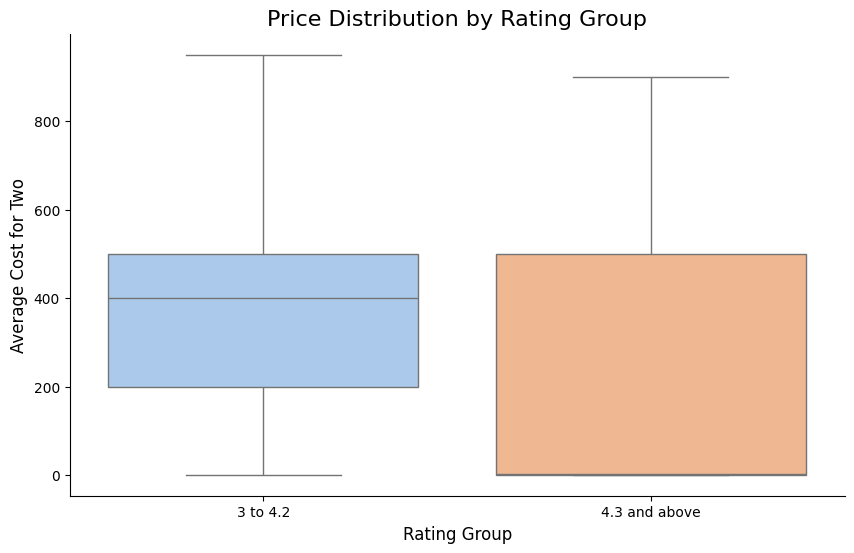

/var/folders/49/z4dsjwnj3bz30nknl9ffld4h0000gn/T/ipykernel_16791/590749209.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rating_group', y='online_order', data=df, palette='muted')


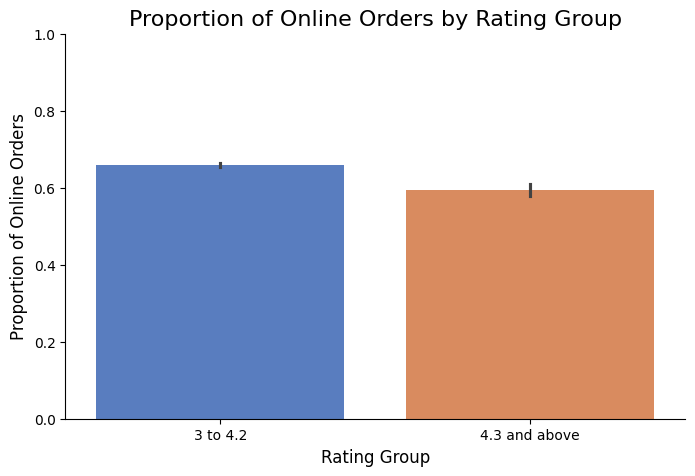

/var/folders/49/z4dsjwnj3bz30nknl9ffld4h0000gn/T/ipykernel_16791/590749209.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='online_order', y='rate', data=df, palette='cool')


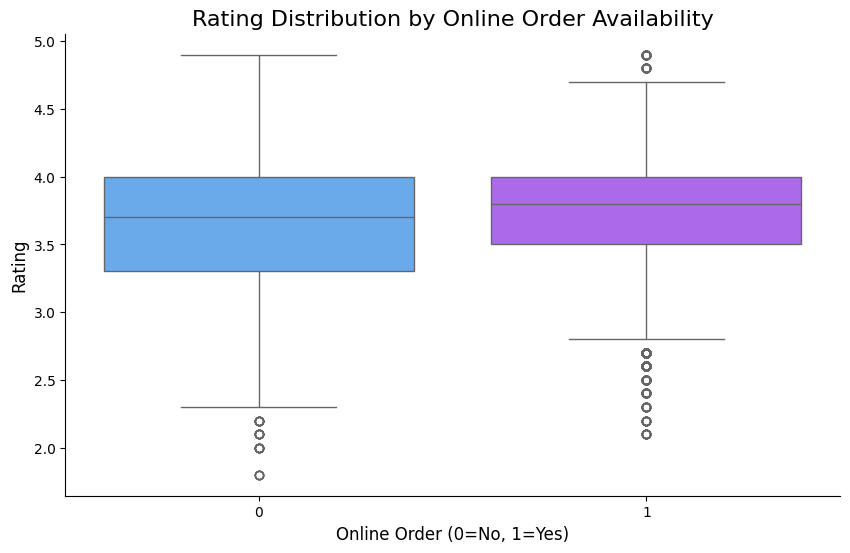

In [307]:
## Trying to find the reason behind the online order count variation with respect to rating
## Finding->
## code logic-chatGPT+ me
# Step: Visualize average cost by rating group
plt.figure(figsize=(10,6))
sns.boxplot(x='rating_group', y='approx_cost', data=df, palette='pastel')
plt.title("Price Distribution by Rating Group", fontsize=16)
plt.xlabel("Rating Group", fontsize=12)
plt.ylabel("Average Cost for Two", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine()
plt.show()

# Step: Visualize online order proportion by rating group
plt.figure(figsize=(8,5))
sns.barplot(x='rating_group', y='online_order', data=df, palette='muted')
plt.title("Proportion of Online Orders by Rating Group", fontsize=16)
plt.xlabel("Rating Group", fontsize=12)
plt.ylabel("Proportion of Online Orders", fontsize=12)
plt.ylim(0,1)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine()
plt.show()


# Step: Optional: Boxplot of ratings vs online order availability
plt.figure(figsize=(10,6))
sns.boxplot(x='online_order', y='rate', data=df, palette='cool')
plt.title("Rating Distribution by Online Order Availability", fontsize=16)
plt.xlabel("Online Order (0=No, 1=Yes)", fontsize=12)
plt.ylabel("Rating", fontsize=12)
sns.despine()
plt.show()


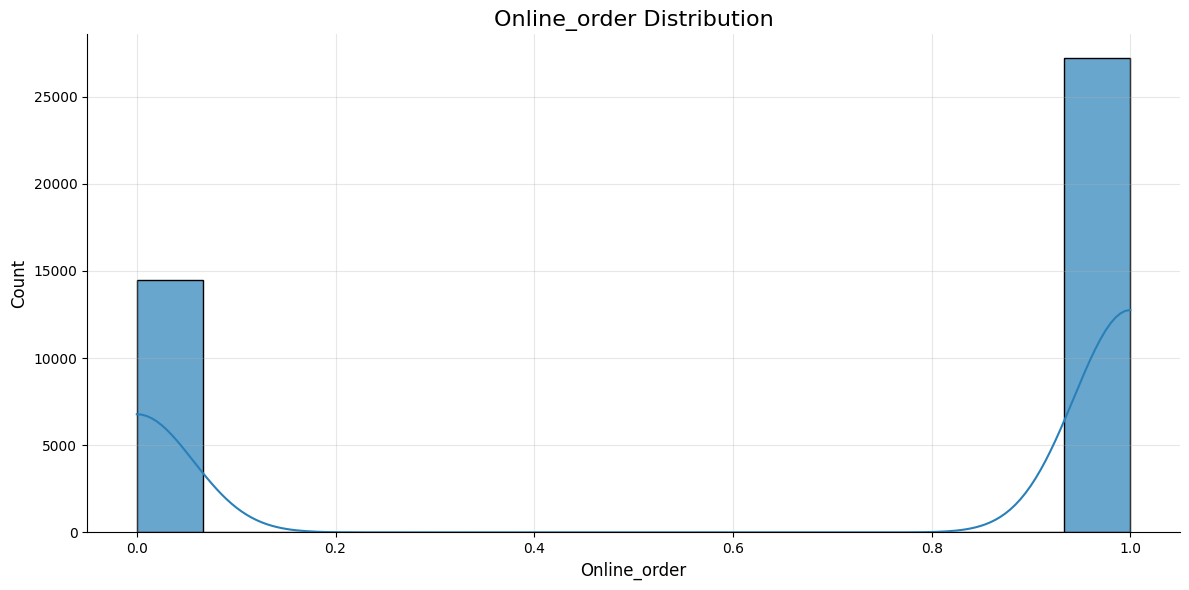

✅ Histogram saved as 'online_order_distribution.png'


In [ ]:
hist_plot(df, 'online_order', "online_order_distribution.png")

In [312]:
df.head(1)

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost,reviews_list,menu_item,type,city,rating_group
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,1,Yes,4.1,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari,3 to 4.2


✅ Auto-saved: visualizations/delivery_booktable_fraction.png


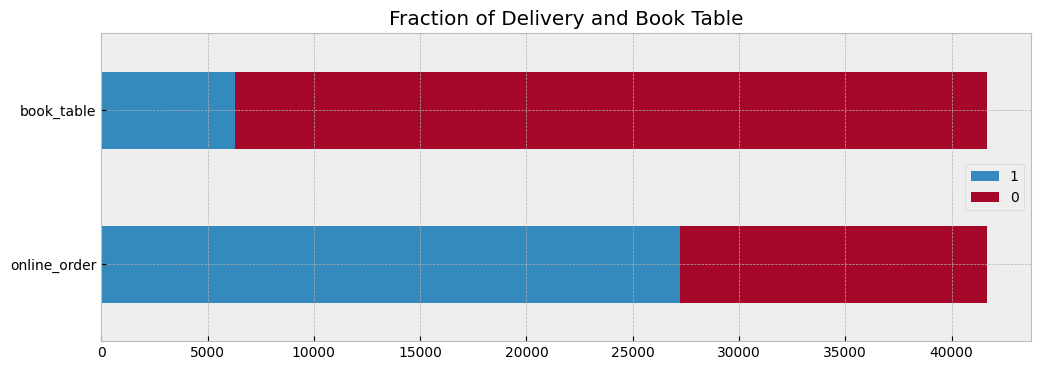

In [320]:
with plt.style.context('bmh', after_reset = True):
    plt.figure(figsize = (12,4))
    ax = plt.subplot(1,1,1)
    tmp = {}
    for col in ['online_order', 'book_table']: 
        tmp[col] = df[col].value_counts()
    tmp = pd.DataFrame.from_dict(tmp, orient = 'index')
    tmp.plot.barh(stacked = True, ax = ax)
    ax.set_title('Fraction of Delivery and Book Table')
    plt.show("delivery_booktable_fraction")

In [ ]:
# Pie chart showing Zomato's presence in various locations of Bangalore
# used ChatGPT to beautify the pie chart->

# labels = list(df.location.value_counts().index)
# values = list(df.location.value_counts().values)
# 
# fig = {
#     "data":[
#         {
#             "labels" : labels,
#             "values" : values,
#             "hoverinfo" : 'label+percent',
#             "domain": {"x": [0, .9]},
#             "hole" : 0.6,
#             "type" : "pie",
#             "rotation":120,
#         },
#     ],
#     "layout": {
#         "title" : "Zomato's Presence in Bangalore",
#         "annotations": [
#             {
#                 "font": {"size":20},
#                 "showarrow": True,
#                 "text": "Neighborhood",
#                 "x":0.2,
#                 "y":0.9,
#             },
#         ]
#     }
# }
# 
# plot(fig)


'temp-plot.html'

## Map 

### Getting coordinates from location column

In [ ]:
## Zomato Presence across Bangalore


## coordinates of Bangalore->
from geopy.geocoders import Nominatim # ''' Nominatim is a free geocoding service from OpenStreetMap — it converts human-readable locations (like “Koramangala, Bengaluru”) into latitude and longitude coordinates. '''
location = [x for x in df['location'].unique().tolist() if type(x) == str]
latitude = []
longitude =  []
for i in range(0, len(location)):
    if(type(location[i]) == str):
        ctr=0
        while True:
            try:
                address = location[i] + ', Bengaluru, India'
                geolocator = Nominatim(user_agent="ny_explorer") #This is the actual API call to OpenStreetMap’s Nominatim service.
                '''It searches for “Indiranagar, Bengaluru, India” If found, it returns a location object with: numerical latitude and longitude coordinates.'''
                loc = geolocator.geocode(address)
                latitude.append(loc.latitude)
                longitude.append(loc.longitude)
                print('The geograpical coordinate of location are {}, {}.'.format(loc.latitude, loc.longitude))
            except:
                ctr+=1
                if(ctr==7):
                    print(i)
                    latitude.append(address)
                    longitude.append(address)
                    break
                continue
            break



The geograpical coordinate of location are 12.9278196, 77.556621.
The geograpical coordinate of location are 12.9417261, 77.5755021.
The geograpical coordinate of location are 12.9466619, 77.5300896.
The geograpical coordinate of location are 12.9292731, 77.5824229.
The geograpical coordinate of location are 12.9067683, 77.5595021.
The geograpical coordinate of location are 12.9274413, 77.5155224.
The geograpical coordinate of location are 12.9660726, 77.6125941.
The geograpical coordinate of location are 12.9055682, 77.5455438.
The geograpical coordinate of location are 12.9096941, 77.5866067.
The geograpical coordinate of location are 12.9287596, 77.6287122.
The geograpical coordinate of location are 12.965718, 77.5762705.
The geograpical coordinate of location are 12.8773175, 77.595188.
The geograpical coordinate of location are 12.9112759, 77.6045654.
The geograpical coordinate of location are 12.8712415, 77.5385451.
The geograpical coordinate of location are 12.9089453, 77.6239038

### Getting coordinated from the location column

In [329]:
df['location_latitude'] = df['location'].map(dict(zip(location, latitude)))
df['location_longitude'] = df['location'].map(dict(zip(location, longitude)))

In [340]:
for lat in df['location_latitude'].unique():
    if type(lat) == str:
        df = df[df['location_latitude'] != lat]

for lng in df['location_longitude'].unique():
    if type(lng) == str:
        df = df[df['location_longitude'] != lng]
df['location_latitude'] = df['location_latitude'].astype(float)
df['location_longitude'] = df['location_longitude'].astype(float)

In [341]:
df['location_latitude'].unique()

array([12.9278196, 12.9417261, 12.9466619, 12.9292731, 12.9067683,
       12.9274413, 12.9660726, 12.9055682, 12.9096941, 12.9287596,
       12.965718 , 12.8773175, 12.9112759, 12.8712415, 12.9089453,
       12.8487599, 12.9239386, 12.9489339, 12.9555367, 12.9348429,
       12.9657678, 12.9116225, 12.9364846, 12.9361208, 12.9552572,
       12.9963995, 12.9736253, 12.9582766, 12.9732913, 12.9277245,
       12.9975851, 12.9755264, 12.9673575, 12.9712421, 12.9734314,
       12.9778793, 12.9666878, 12.9855286, 12.982005 , 12.9758014,
       12.9884255, 12.9835482, 12.9822423, 12.9921738, 12.9624669,
       12.9408685, 12.945245 , 12.9678074, 13.0082277, 12.9931876,
       13.0148544, 12.9390255, 12.9779079, 12.957998 , 12.9730087,
       12.9652094, 12.9625188, 12.9243692, 12.9282918, 12.9327778,
       12.9357366, 12.8943812, 13.0227204, 13.0141618, 13.0222347,
       13.0422794, 13.037077 , 13.0221416, 13.031992 , 12.8744383,
       12.9850987, 12.9846713, 12.9176571, 12.9967842, 13.0027

In [333]:
df.groupby(['location'])['rate'].mean().sort_values()[-50:][:-1]

location
Vijay Nagar              3.604687
Frazer Town              3.614912
Rajajinagar              3.615401
Whitefield               3.621618
Central Bangalore        3.625000
Sahakara Nagar           3.633333
Yelahanka                3.640000
Basaveshwara Nagar       3.646715
Banashankari             3.649866
Old Airport Road         3.654190
Mysore Road              3.658824
Kammanahalli             3.667465
Basavanagudi             3.671092
HSR                      3.672164
JP Nagar                 3.675306
HBR Layout               3.676768
Vasanth Nagar            3.683265
Sarjapur Road            3.686143
New BEL Road             3.688976
Koramangala 1st Block    3.696831
Seshadripuram            3.704930
Brigade Road             3.705228
Kengeri                  3.722222
Koramangala              3.726667
Koramangala 8th Block    3.731897
Koramangala 2nd Block    3.749425
Ulsoor                   3.758304
Malleshwaram             3.759657
Koramangala 6th Block    3.778087
Jayan

In [342]:
## Map of Zomato's restaurant locations in Bangalore
# Create a map centered around Bangalore

dataframe_filtered = df.groupby(['location'])[['location_latitude', 'location_longitude']].first()
dataframe_filtered['no_restaurant'] = df.groupby(['location'])['url'].count()
venues_map = folium.Map(location=[12.934533, 77.626579], zoom_start=11) # generate map centred around Bengaluru

states = folium.map.FeatureGroup()
i=0
for lat, lng, in zip(dataframe_filtered.location_latitude, dataframe_filtered.location_longitude):
    states.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
        )
    )
    i+=1
i=0
for lat, lng, in zip(dataframe_filtered.location_latitude, dataframe_filtered.location_longitude):
    states.add_child(
        folium.features.Marker(
            [lat, lng],
            popup= dataframe_filtered.index[i],
        )
    )
    i+=1
# add incidents to map
venues_map.add_child(states)
venues_map

In [336]:
print(df.columns)


Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost', 'reviews_list', 'menu_item', 'type', 'city',
       'rating_group', 'location_latitude', 'location_longitude'],
      dtype='object')


In [338]:
dataframe_filtered = (
    df.groupby('location')
      .agg({'location_latitude': 'first', 'location_longitude': 'first', 'url': 'count'})
      .rename(columns={'url': 'no_restaurant'})
)

venues_map = folium.Map(location=[12.9716, 77.5946], zoom_start=11)

for idx, row in dataframe_filtered.iterrows():
    folium.CircleMarker(
        location=[float(row['location_latitude']), float(row['location_longitude'])],
        radius=5 + row['no_restaurant'] * 0.01,  # bubble size based on restaurant count
        color='blue',
        fill=True,
        fill_color='lightblue',
        fill_opacity=0.6,
        popup=f"{idx} — {row['no_restaurant']} restaurants"
    ).add_to(venues_map)

venues_map.save("bangalore_restaurants_map.html")
print("✅ Map saved as 'bangalore_restaurants_map.html'")


ValueError: could not convert string to float: 'ITPL Main Road, Whitefield, Bengaluru, India'